# Import libraries

In [120]:
import pandas as pd
import re
import string
import spacy

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Get Data from Wikipedia

I follow the tutorial at https://www.mediawiki.org/wiki/API:Tutorial. I decided to use the url for wikipedia since that way I have obtained more results (at least 200 different data records needed)

In [121]:
import pandas as pd

url = 'https://en.wikipedia.org/w/api.php'

In [122]:
params = {
    "action": "query",
    "list": "mostviewed", # get most viewed articles
    "pvimlimit": 20, # limit the result to 200
    "format" : "json"
}

In [123]:
import requests
r = requests.get(url, params=params)
print(r)

<Response [200]>


In [124]:
r.json()

{'batchcomplete': '',
 'continue': {'pvimoffset': 20, 'continue': '-||'},
 'query': {'mostviewed': [{'ns': 0, 'title': 'Main Page', 'count': 4843810},
   {'ns': 0, 'title': 'Aaron Carter', 'count': 2155996},
   {'ns': -1, 'title': 'Special:Search', 'count': 1220835},
   {'ns': 0, 'title': "ICC Men's T20 World Cup", 'count': 1151252},
   {'ns': 0, 'title': "2022 ICC Men's T20 World Cup", 'count': 511354},
   {'ns': 0, 'title': 'Dusty Baker', 'count': 448404},
   {'ns': 0, 'title': 'Leslie Carter', 'count': 398543},
   {'ns': 0, 'title': 'Nick Carter (singer)', 'count': 357446},
   {'ns': 0, 'title': 'Premier League', 'count': 220874},
   {'ns': 0, 'title': 'Coy Gibbs', 'count': 187686},
   {'ns': 0, 'title': 'Cleopatra', 'count': 184335},
   {'ns': 0, 'title': 'Alia Bhatt', 'count': 182574},
   {'ns': 0, 'title': 'Sally McNeil', 'count': 170187},
   {'ns': 4, 'title': 'Wikipedia:Featured pictures', 'count': 169466},
   {'ns': 0, 'title': 'Luke Evans', 'count': 164916},
   {'ns': 0, 'tit

In [125]:
# Get titles:
article_titles = []
article_views = []
for idx, x in enumerate(r.json()['query']['mostviewed']):
    # I will not include the pages "Main Page" and "Special:Search".
    if (x['title'] != 'Main Page' and x['title'] != 'Special:Search'):
        article_titles.append(x['title'])
        article_views.append(x['count'])

In [126]:
import pandas as pd
df = pd.DataFrame(columns=['Title', 'Text', 'Views'])
df['Title'] = article_titles
df['Views'] = article_views
df.head()

,Title,Text,Views
0,Aaron Carter,NaN,2155996
1,ICC Men's T20 World Cup,NaN,1151252
2,2022 ICC Men's T20 World Cup,NaN,511354
3,Dusty Baker,NaN,448404
4,Leslie Carter,NaN,398543


In [127]:
# Create a scrapper:
from bs4 import BeautifulSoup
import re

def getWikiText(html_txt):
    soup = BeautifulSoup(html_txt, 'html.parser')
    # we are interested in those that are tagged as <p> which stands for paragraphs.
    text = ''
    for paragraph in soup.find_all('p'):
        text += paragraph.text
        # Let’s do a little bit of cleaning to get the exact output from the previous section
    text = re.sub(r'\[.*?\]+', '', text)
    text = text.replace('\n', '')
    return text


In [128]:
# Request the article for each page:

for idx, title in enumerate(df['Title']):
    params = {
        "action": "parse",
        "prop": "text",
        "page": title,
        "format" : "json"
    }
    try:
        request = requests.get(url, params=params)
        if request.status_code != 200:
            raise Exception(f"Download failed with code {request.status_code}")
        else:
            df.at[idx, 'Text']= getWikiText(request.json()['parse']['text']['*'])
    except Exception as e:
        print(e)

In [129]:
df.head()

,Title,Text,Views
0,Aaron Carter,"Aaron Charles Carter (December 7, 1987 – Novem...",2155996
1,ICC Men's T20 World Cup,The ICC Men's T20 World Cup (earlier known as ...,1151252
2,2022 ICC Men's T20 World Cup,The 2022 ICC Men's T20 World Cup is the eighth...,511354
3,Dusty Baker,"As managerAs coachJohnnie B. ""Dusty"" Baker Jr....",448404
4,Leslie Carter,"Leslie Barbara Carter (June 6, 1986 – January ...",398543


In [130]:
df.to_csv('most_watched_wiki_articles.csv')

In [131]:
df.shape

(18, 3)

# Statistic representation

## Article lengths

In [132]:
# Get Lengths of text
for idx, article in enumerate(df['Text']):
  df.at[idx, 'Length'] = len(article)

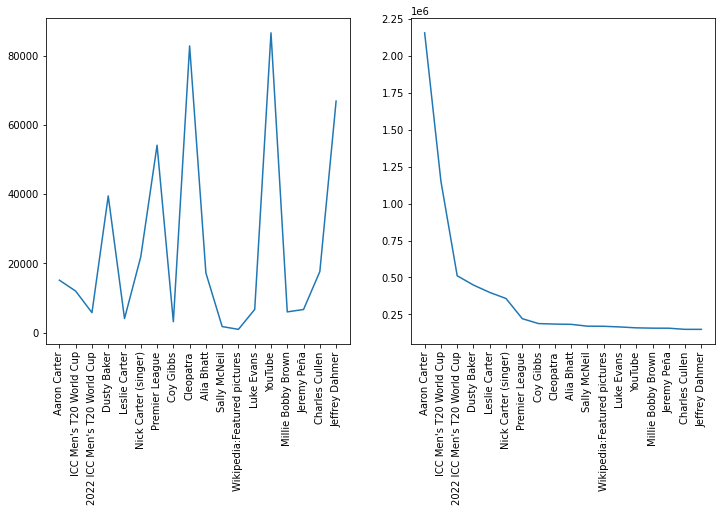

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (pic1, pic2) = plt.subplots(1, 2, figsize=(12,6))
for tick in pic1.get_xticklabels():
    tick.set_rotation(90)
for tick in pic2.get_xticklabels():
    tick.set_rotation(90)
pic1.plot(df['Title'], df['Length'])
pic2.plot(df['Title'], df['Views'])
plt.show()


## Word frequencies

I created bag of words to see which words are used in each article. 

#### Preprocess data

In [134]:
import string 

# Convert uppercase to lowercase
corpus = [document.lower() for document in df['Text']]

# Remove end of line
# corpus = [(re.sub(r'\n', '' , document)) for document in corpus]

# Remove digits
corpus = [(re.sub(r'\d', '' , document)) for document in corpus]

# Remove punctuation marks
pattern = r'[' + re.escape(string.punctuation) + ']'
corpus = [(re.sub(pattern, '' , document)) for document in corpus]
corpus = [(re.sub('–', '' , document)) for document in corpus]

# Remove superflous blanks
corpus = [(re.sub(r' +', ' ', document)) for document in corpus]

In [135]:
# Tokenize
tokens = [nltk.word_tokenize(document) for document in corpus]

In [136]:
#loading the english language of spacy and stopwords.
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

# Delete stopwords
tokenized_corpus = []
for document in tokens:
    tokenized_corpus.append([token for token in document if token not in sw_spacy])

In [137]:
print(tokenized_corpus[0])

['aaron', 'charles', 'carter', 'december', 'november', 'american', 'singer', 'songwriter', 'came', 'fame', 'teen', 'pop', 'singer', 'late', 's', 'establishing', 'star', 'preteen', 'teenage', 'audiences', 'years', 'st', 'century', 'studio', 'albumscarter', 'began', 'performing', 'age', 'seven', 'released', 'selftitled', 'debut', 'album', 'age', 'selling', 'million', 'copies', 'worldwide', 'second', 'album', 'aarons', 'party', 'come', 'sold', 'million', 'copies', 'united', 'states', 'carter', 'began', 'making', 'guest', 'appearances', 'nickelodeon', 'touring', 'backstreet', 'boys', 'shortly', 'records', 'release', 'carters', 'album', 'oh', 'aaron', 'went', 'platinum', 'musician', 'released', 'studio', 'album', 'years', 'earthquake', 'followed', 'requested', 'hits', 'collectioncarter', 'appeared', 'dancing', 'stars', 'broadway', 'musical', 'seussical', 'offbroadway', 'musical', 'fantasticks', 'oneoff', 'performances', 'released', 'single', 'featuring', 'rapper', 'pat', 'solo', 'ooh', 'wee

In [139]:
# Lemmatize
lemmatizer = WordNetLemmatizer()
lemmatized_corpus = []
df['Tokens'] = None
for idx, document in enumerate(tokenized_corpus):
    lemmatized_corpus.append([lemmatizer.lemmatize(token) for token in document])
    s = ' '.join(document)
    df['Tokens'].iat[idx] = s

In [140]:
df.head()

,Title,Text,Views,Length,Tokens
0,Aaron Carter,"Aaron Charles Carter (December 7, 1987 – Novem...",2155996,15185.0,aaron charles carter december november america...
1,ICC Men's T20 World Cup,The ICC Men's T20 World Cup (earlier known as ...,1151252,12034.0,icc mens t world cup earlier known icc world i...
2,2022 ICC Men's T20 World Cup,The 2022 ICC Men's T20 World Cup is the eighth...,511354,5816.0,icc mens t world cup eighth icc mens t world c...
3,Dusty Baker,"As managerAs coachJohnnie B. ""Dusty"" Baker Jr....",448404,39497.0,manageras coachjohnnie b dusty baker jr born j...
4,Leslie Carter,"Leslie Barbara Carter (June 6, 1986 – January ...",398543,4115.0,leslie barbara carter june january american si...


#### Create Bag of Words

Through the bag of words we can see the word frequency in a vocabulary. To do the bag of words I have used a CountVectorizer. 

In [141]:
# Create bag of words with vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')

In [142]:
matrix = vectorizer.fit_transform(df['Tokens']).toarray()

In [143]:
bag_of_words = pd.DataFrame(data = matrix, columns = vectorizer.get_feature_names_out())
display(bag_of_words)

,aa,aac,aadvanced,aaron,aarons,abandon,abandoned,abandoning,abandonment,abbreviated,...,κλεοπάτρα,κλεόπατρος,κνῆστις,οὑ,πάτροκλος,πατήρ,φιλοπάτωρ,φιλοπάτωρα,五毛,共匪
0,0,0,0,9,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,1,3,1,0,0,...,2,1,1,1,1,1,1,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create a Word Cloud for the 9 most watched

Source: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

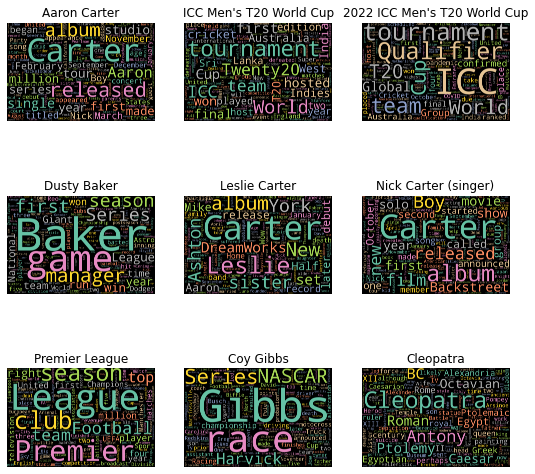

In [144]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

for idx, text in enumerate(df['Text'][0:9]): 
  plt.subplot(3, 3, idx+1)
  wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
  plt.imshow(wordcloud)
  plt.title(f"{df['Title'].iloc[idx]}")
  plt.axis('off')

# Similarity of articles

Sources: 
* https://towardsdatascience.com/the-best-document-similarity-algorithm-in-2020-a-beginners-guide-a01b9ef8cf05



# Clustering and Machine Learning